## Basic Setup

In [1]:
%pip install seaborn tikzplotlib
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import tikzplotlib

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=True)

DF = pd.read_csv('../orcas.tsv', sep='\t', header=None, names=['query', 'docid'])
docid_counts = DF.groupby('docid').count()

def get_embeddings(n_docids, n_queries, min_pop, max_pop):
    """
    Get embeddings of queries grouped by documents

    Arguments:
    n_docids - number of docs
    n_queries - number of queries per doc
    min_pop - minimum popularity in terms of associated queries per doc
    max_pop - maximum popularity in terms of associated queries per doc
    """
    if min_pop is None:
        min_pop = n_queries
    elif min_pop < n_queries:
        raise Exception('min_pop cannot be smaller than n_queries')

    filter = (docid_counts['query'] >= min_pop)
    if max_pop is not None:
        filter &= (docid_counts['query'] < max_pop)
    
    eligible_docids = docid_counts[filter].index
    df = DF[DF['docid'].isin(eligible_docids)]
    sampled_docids = df['docid'].drop_duplicates().sample(n=n_docids)

    doc_embeddings = torch.empty((0, model.encoder.config.hidden_size), dtype=torch.float32)
    for docid in sampled_docids:
        queries = df[df['docid'] == docid].sample(n=n_queries)['query'].tolist()
        inputs = [tokenizer(query, return_tensors='pt').input_ids for query in queries]
        
        with torch.no_grad():
            query_embeddings = torch.stack([model.encoder(input_ids=input_ids).last_hidden_state.mean(dim=1) for input_ids in inputs]).squeeze(1)
        
        doc_embeddings = torch.cat((doc_embeddings, query_embeddings), dim=0)

    return doc_embeddings

Note: you may need to restart the kernel to use updated packages.


/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plotting

/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcel/anaconda3/envs/mtgjamendo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:title={'center':'Query Clustering Grouped by Documents (Doc Popoularity 1000-None)'}>

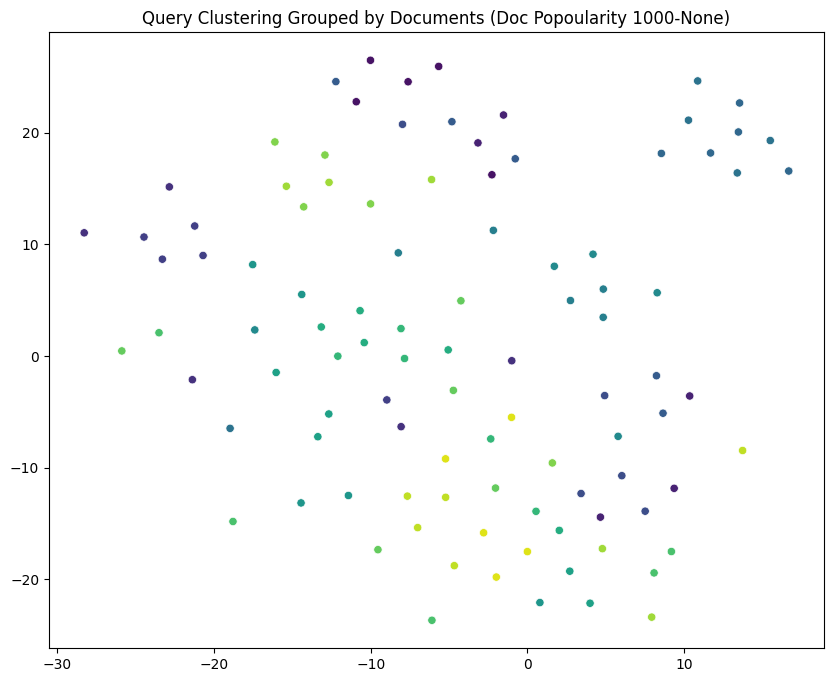

In [121]:
# Parameters
n_docs = 10
n_queries = 10
min_pop = 1000
max_pop = None

doc_embeddings = get_embeddings(n_docs, n_queries, min_pop, max_pop)

# 2D Reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(doc_embeddings.numpy())
n_embeddings_per_doc = len(doc_embeddings) // len(sampled_docids)
doc_labels = np.repeat(sampled_docids, n_embeddings_per_doc)

plt.figure(figsize=(10, 8))
plt.title(f'Query Clustering Grouped by Documents (Doc Popoularity {min_pop}-{max_pop})')
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=doc_labels.astype(str), palette='viridis', legend=False)

## Export to TikZ/TeX

In [124]:
tikzplotlib.save(
    f'../plots/cluster_{n_queries}q_{n_docs}d_pop{min_pop}{"-" + str(max_pop) if max_pop is not None else ""}.tex',
    axis_width=r'\columnwidth', axis_height=r'6cm'
)

<Figure size 640x480 with 0 Axes>